### Comparing the Color of Lenses

Jenny Kim, Phil Marshall

The OM10 mock lensed quasar catalog `qso_mock.fits` contains estimates of the lens galaxy $i$-band magnitudes, based on a simple Faber-Jackson scaling implemented by Phil Marshall. With the `lenspop` library we can compute synthetic magnitudes in any filter. In this notebook, we will look at the differences in the distributions of the 1) redshift, 2) $i$-band magnitude, 3) $G-R$ magnitude, 4) $R-I$ magnitude, and 5) $I-Z$ magnitude between the known SDSS values and the colored magnitudes for each lens by drawing a cornerplot.

### Requirements

`om10`, `qso_mock.fits`, and `om10`'s dependencies:

In [1]:
import warnings
warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2
%matplotlib inline 

In [2]:
from __future__ import division
import os, numpy as np
import corner
import om10
from om10 import plotting
from astropy.table import Table
import matplotlib
matplotlib.use('TkAgg')
matplotlib.rc('text', usetex=False)

First, let's read the catalog and select 200 lenses whose magnitude is smaller than 27. Then, let's paint the lenses.

In [3]:
db = om10.DB(catalog='/Users/Jenny/Desktop/om10fork/om10/data/qso_mock.fits')
db.select_random(Nlens=200,maglim=23.6)
db.paint(synthetic=True, target='lens')

om10.DB: selection yields  200  lenses
200


Draw the cornerplot with the arguments in axis_labels and save it first so that we could overlap it with the second cornerplot. Two cornerplot seems a lot, but corner.corner automatically displays the cornerplot in jupyter. However, using %%capture stops jupyter displaying the cornerplot.

In [5]:
# We need only one cornerplot in one notebook, so don't show output by having the command below
%%capture
fig = om10.plot_sample(db.sample, color='blue', parameters=('MAGI','ZLENS', 'GR', 'RI', 'IZ'))

We initialize the array for redshift, $i$-magnitude, $G-R$ magnitude, $R-I$ magnitude, and $I-Z$ magnitude. Then, we select 50 random numbers from 0 to length of qso array, painting them with the color_demo file which extends lenspop library to compute the synthetic magnitude.

In [6]:
axis_labels = {}
axis_labels['ZLENS'] = '$z_d$'
axis_labels['MAGI'] = '$i_3$'
axis_labels['GR'] = '$G-R$'
axis_labels['RI'] = '$R-I$'
axis_labels['IZ'] = '$I-Z$'

Then, we will overlap the synthetically colored samples with the original data. Ideally, the distributions of the data should be similar, and the blue contours and the red contours should have significant overlap. While plotting the data onto the cornerplot, we should eliminate the outliers.

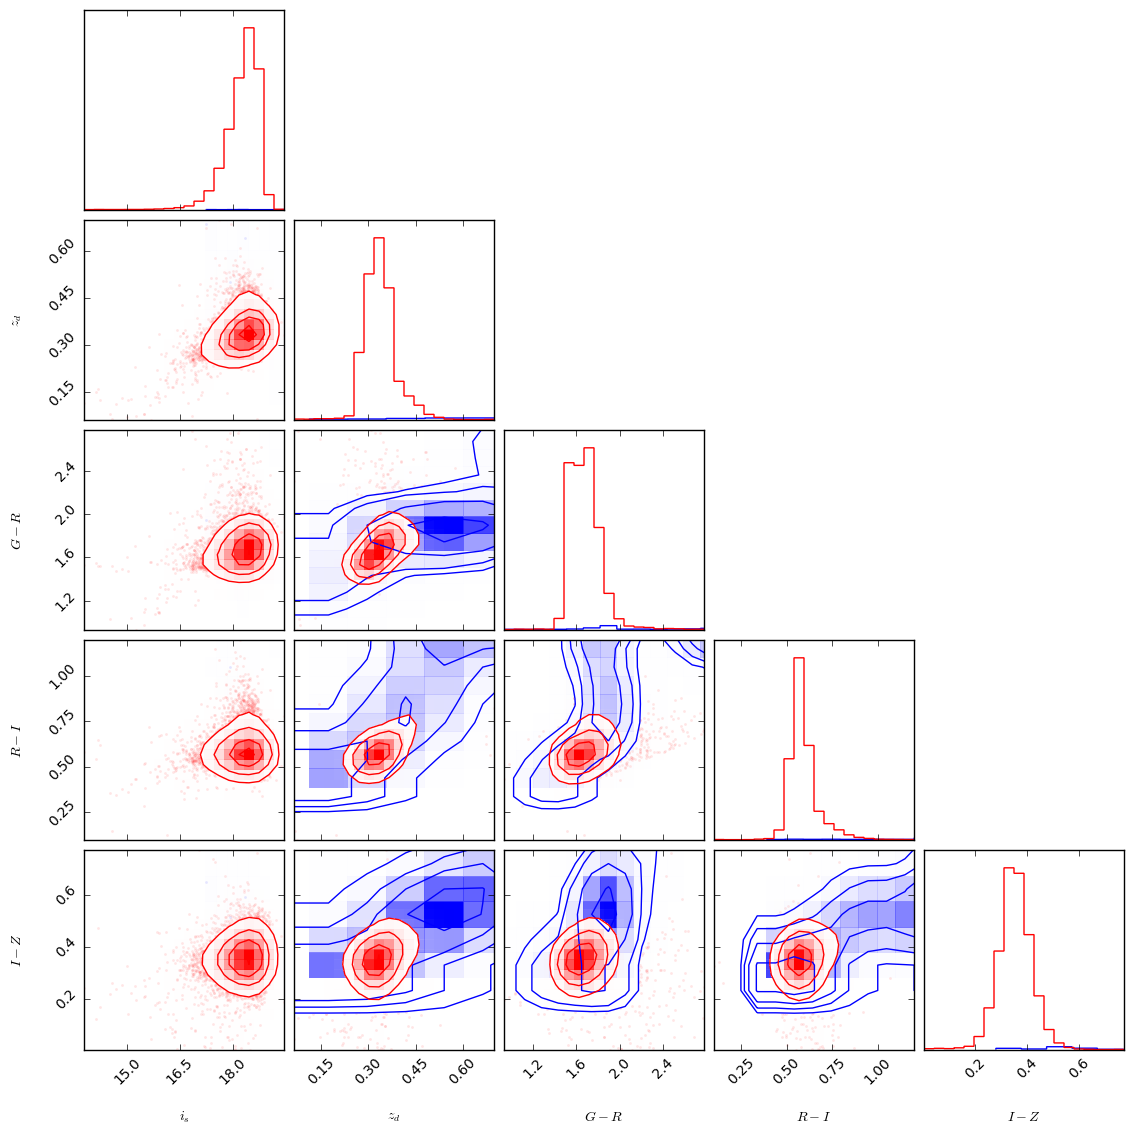

In [7]:
# Columns : ra  dec  z  mag_u  mag_g  mag_r  mag_i  mag_z
table = np.loadtxt('../data/SDSS_LRGs.txt')
# eliminate outliers using original data
table = table[np.logical_and(table[:,6]<23.6, table[:,2]<3, 14<table[:,6])]
z = table[:,2]
i = table[:,6]
gr = table[:,4]-table[:,5]
ri = table[:,5]-table[:,6]
iz = table[:,6]-table[:,7]

# eliminate outliers after the operation
# gr = table[:,4]-table[:,5], iz = table[:,6]-table[:,7]
z = z[(0<table[:,6]-table[:,7]) & (table[:,4]-table[:,5]<2.8)]
i = i[(0<table[:,6]-table[:,7]) & (table[:,4]-table[:,5]<2.8)]
gr = gr[(0<table[:,6]-table[:,7]) & (table[:,4]-table[:,5]<2.8)]
ri = ri[(0<table[:,6]-table[:,7]) & (table[:,4]-table[:,5]<2.8)]
iz = iz[(0<table[:,6]-table[:,7]) & (table[:,4]-table[:,5]<2.8)]

data = Table({'MAGI': i, 'ZLENS': z, 'GR': gr, 'RI': ri, 'IZ': iz}, names=['MAGI', 'ZLENS', 'GR', 'RI', 'IZ'])
features, labels = plotting.extract_features(data, ('MAGI','ZLENS', 'GR', 'RI', 'IZ'))
corner.corner(features, labels=labels, color='red', smooth=1.0, fig=fig)

### Discussion

Red(the real data) and the blue(synthetically colored data) contours somewhat look similar to each other, but the blue data did not have the exact same boundary with the red data. Just like QuasarColorMagnitude, the biggest problem seems to be the differences in $i$-magnitude. It might be worth double-checking the synthetic magnitude calculation.